# 環境設定與載入函式庫

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 安裝運行此筆記本可能需要的額外函式庫
# 如果您是第一次使用，請取消以下這行的註解並執行
# !pip install emoji textstat

import emoji
import textstat

# --- 視覺化設定 ---
# 設定 seaborn 的繪圖風格
sns.set_style('whitegrid')
# 解決 Matplotlib 中文顯示問題
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Heiti TC', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
# 設定 pandas 顯示選項
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 150)

print("函式庫載入完成！")

函式庫載入完成！


# 載入資料與基礎預處理

In [3]:
# --- 載入資料 ---
try:
    df = pd.read_csv('train.csv')
    print("train.csv 載入成功！")
except FileNotFoundError:
    print("錯誤：請確認 'train.csv' 檔案與此筆記本在同一個資料夾下！")
    # 如果在 Colab，你需要上傳檔案

# --- 基礎預處理 ---
# 1. 創建一個統一的 'label' 欄位，方便後續分析
#    0: model_a 勝, 1: model_b 勝, 2: 平手
def get_label(row):
    if row['winner_model_a'] == 1:
        return 0
    if row['winner_model_b'] == 1:
        return 1
    return 2

df['label'] = df.apply(get_label, axis=1)

# 2. (可選) 清理 prompt/response 欄位中可能存在的多餘引號或空格
for col in ['prompt', 'response_a', 'response_b']:
    # 確保所有內容都是字串類型，避免後續處理出錯
    df[col] = df[col].astype(str).str.strip()

# --- 顯示資料概覽 ---
print("\n資料前 3 筆:")
print(df.head(3))

print("\nLabel (目標變數) 分佈:")
# 使用 normalize=True 可以看到百分比
print(df['label'].value_counts(normalize=True).map('{:.2%}'.format))

train.csv 載入成功！

資料前 3 筆:
      id             model_a         model_b                                             prompt                                         response_a  \
0  30192  gpt-4-1106-preview      gpt-4-0613  ["Is it morally right to try to have a certain...  ["The question of whether it is morally right ...   
1  53567           koala-13b      gpt-4-0613  ["What is the difference between marriage lice...  ["A marriage license is a legal document that ...   
2  65089  gpt-3.5-turbo-0613  mistral-medium  ["explain function calling. how would you call...  ["Function calling is the process of invoking ...   

                                          response_b  winner_model_a  winner_model_b  winner_tie  label  
0  ["As an AI, I don't have personal beliefs or o...               1               0           0      0  
1  ["A marriage license and a marriage certificat...               0               1           0      1  
2  ["Function calling is the process of invoking ...   

# 調查項目 1 - 回應的長度

--- 各類別下的平均回應長度 ---
        len_a   len_b
label                
0      1567.6  1314.1
1      1291.3  1569.1
2      1259.2  1265.1


C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\321905276.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\321905276.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


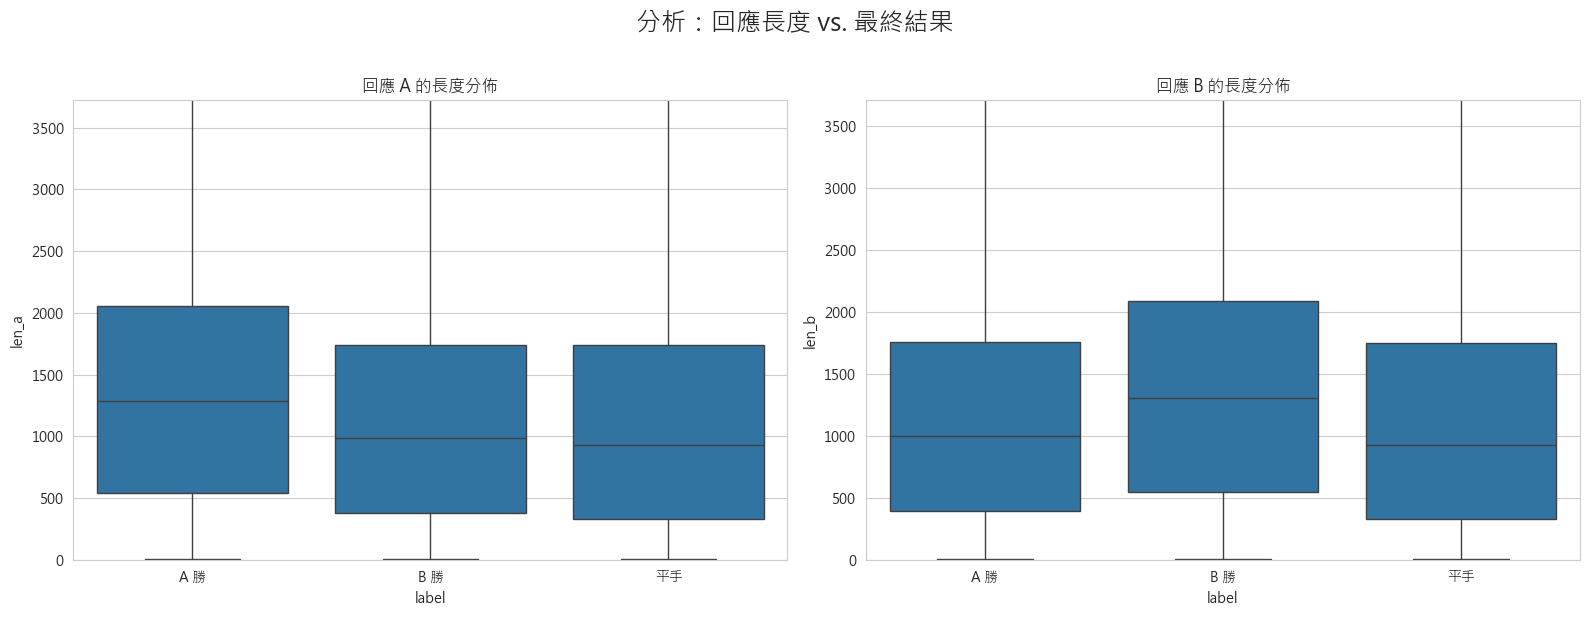


初步結論：
從圖中可以觀察到一個明顯趨勢：
- 當 A 勝 (label=0) 時，回應 A 的長度中位數顯著高於回應 B。
- 當 B 勝 (label=1) 時，回應 B 的長度中位數顯著高於回應 A。
這表明「長度」是一個非常有潛力的特徵！


In [3]:
# --- 特徵工程: 長度相關 ---
df['len_a'] = df['response_a'].str.len()
df['len_b'] = df['response_b'].str.len()
df['len_diff'] = abs(df['len_a'] - df['len_b'])

# --- 數據分析 ---
print("--- 各類別下的平均回應長度 ---")
print(df.groupby('label')[['len_a', 'len_b']].mean().round(1))

# --- 視覺化分析 ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('分析：回應長度 vs. 最終結果', fontsize=18, y=1.02)

# 使用箱形圖 (Box Plot) 來觀察分佈，它比平均數提供更多資訊 (中位數、離群值等)
sns.boxplot(x='label', y='len_a', data=df, ax=axes[0])
axes[0].set_title('回應 A 的長度分佈')
axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
# 由於有些回應非常長，這裡限制 Y 軸範圍以利於觀察主要分佈
axes[0].set_ylim(0, df['len_a'].quantile(0.95))

sns.boxplot(x='label', y='len_b', data=df, ax=axes[1])
axes[1].set_title('回應 B 的長度分佈')
axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])
axes[1].set_ylim(0, df['len_b'].quantile(0.95))

plt.tight_layout()
plt.show()

print("\n初步結論：\n從圖中可以觀察到一個明顯趨勢：\n"
      "- 當 A 勝 (label=0) 時，回應 A 的長度中位數顯著高於回應 B。\n"
      "- 當 B 勝 (label=1) 時，回應 B 的長度中位數顯著高於回應 A。\n"
      "這表明「長度」是一個非常有潛力的特徵！")

# 潛力特徵

In [4]:
# --- 特徵工程: 進階特徵 ---

# 1. 與問題的貼合度 (Jaccard Similarity)
def get_jaccard_similarity(text1, text2):
    set1 = set(str(text1).lower().split())
    set2 = set(str(text2).lower().split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

df['jaccard_a'] = df.apply(lambda row: get_jaccard_similarity(row['prompt'], row['response_a']), axis=1)
df['jaccard_b'] = df.apply(lambda row: get_jaccard_similarity(row['prompt'], row['response_b']), axis=1)

# 2. 結構化特徵 (程式碼區塊 & 列表項目)
def count_code_blocks(text):
    # 計算 markdown 格式的程式碼區塊數量
    return str(text).count('```') // 2

def count_list_items(text):
    # 計算 markdown 格式的列表數量 (*, -, 1.)
    return len(re.findall(r'^\s*[\*\-]\s|\n\s*[\*\-]\s|^\s*\d+\.\s|\n\s*\d+\.\s', str(text), re.MULTILINE))

df['code_a'] = df['response_a'].apply(count_code_blocks)
df['code_b'] = df['response_b'].apply(count_code_blocks)
df['list_a'] = df['response_a'].apply(count_list_items)
df['list_b'] = df['response_b'].apply(count_list_items)

# 3. 可讀性分數 (Flesch Reading Ease)
# 分數越高代表越容易閱讀。90-100: 小學生水平, 60-70: 標準, 0-30: 大學研究生水平
def calculate_readability(text):
    # textstat 對於空字串或極短文本會報錯，這裡做個保護
    if not text or len(text.split()) < 5:
        return -1 # 使用一個特殊值來標記無效分數
    return textstat.flesch_reading_ease(str(text))

df['readability_a'] = df['response_a'].apply(calculate_readability)
df['readability_b'] = df['response_b'].apply(calculate_readability)

print("進階特徵已生成！包含：'jaccard', 'code', 'list', 'readability'")
print("\n特徵預覽:")
print(df[['jaccard_a', 'code_a', 'list_a', 'readability_a', 'jaccard_b', 'code_b', 'list_b', 'readability_b']].head())

進階特徵已生成！包含：'jaccard', 'code', 'list', 'readability'

特徵預覽:
   jaccard_a  code_a  list_a  readability_a  jaccard_b  code_b  list_b  readability_b
0   0.044271       0       0      28.692134   0.061224       0       0      50.653529
1   0.101796       0       0      45.770466   0.064151       0       0      43.998325
2   0.056818       1       0      58.514347   0.028777       2       0      48.466431
3   0.056818       0       0      32.687851   0.072000       0       0      51.943255
4   0.053846       0       0      54.750870   0.094118       0       0      45.039857


# 分析進階特徵

C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3822541923.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3822541923.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


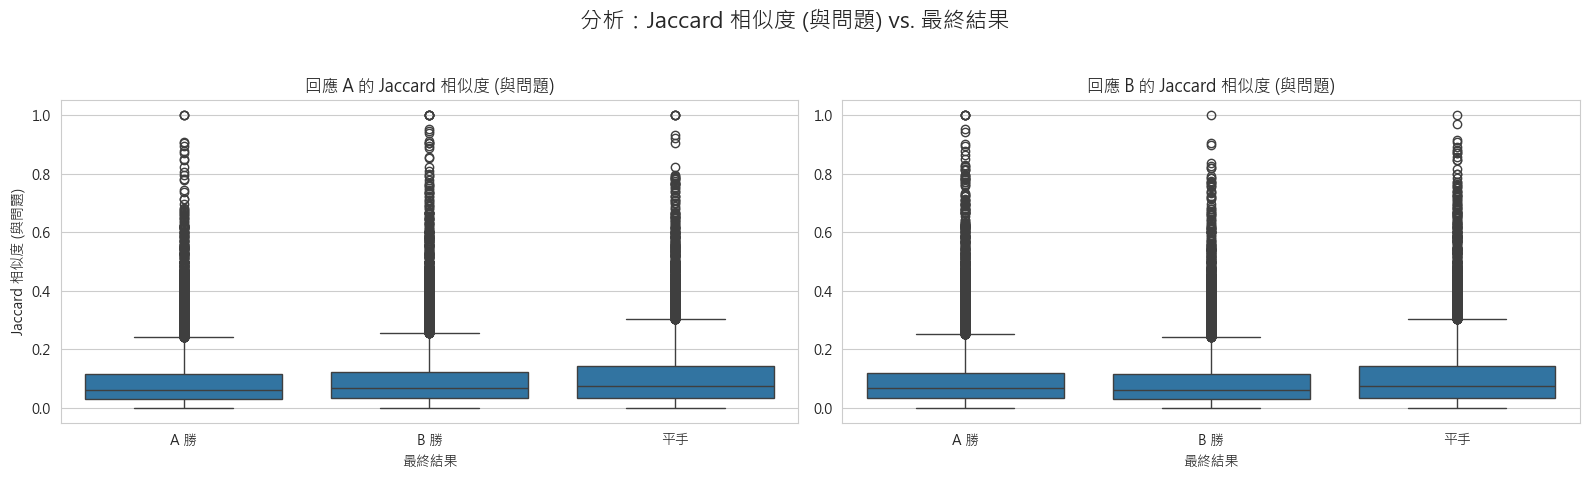

--- Jaccard 相似度 (與問題) 數據摘要 (平均值) ---
       jaccard_a  jaccard_b
label                      
0          0.088      0.093
1          0.094      0.088
2          0.103      0.104
------------------------------------------------------------



C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3822541923.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3822541923.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


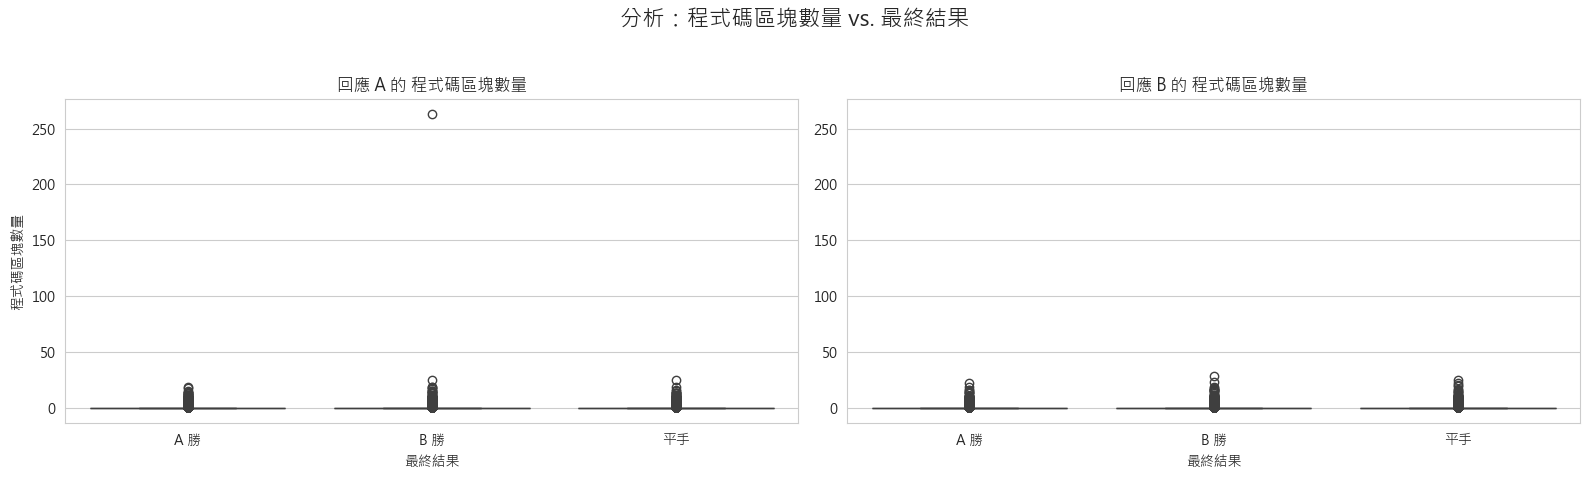

--- 程式碼區塊數量 數據摘要 (平均值) ---
       code_a  code_b
label                
0       0.209   0.166
1       0.195   0.220
2       0.187   0.193
------------------------------------------------------------



C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3822541923.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3822541923.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


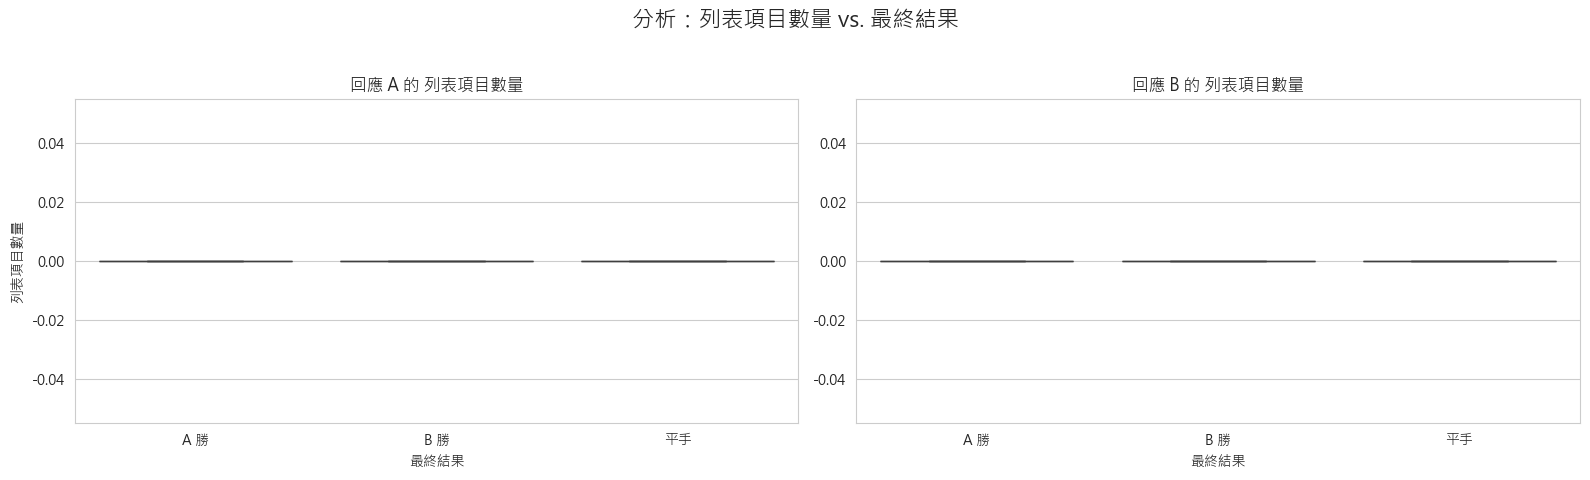

--- 列表項目數量 數據摘要 (平均值) ---
       list_a  list_b
label                
0         0.0     0.0
1         0.0     0.0
2         0.0     0.0
------------------------------------------------------------



C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3822541923.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3822541923.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


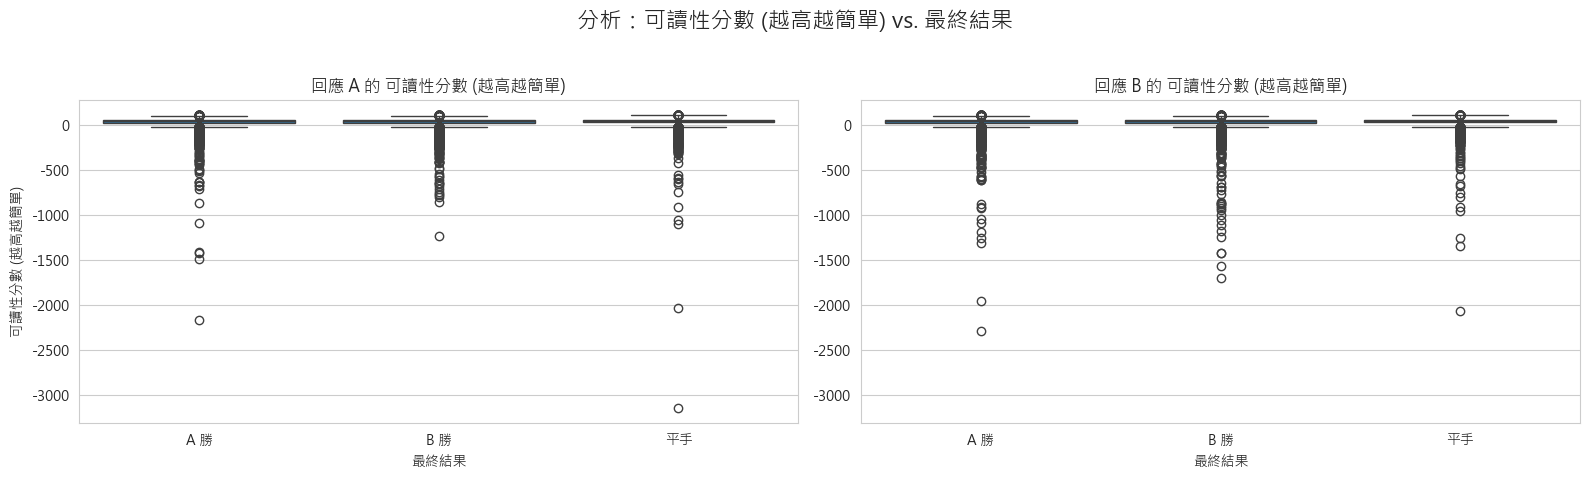

--- 可讀性分數 (越高越簡單) 數據摘要 (平均值) ---
       readability_a  readability_b
label                              
0             43.422         42.484
1             43.236         42.838
2             45.408         45.816
------------------------------------------------------------



In [5]:
# --- 視覺化分析進階特徵 ---
features_to_analyze = {
    'jaccard': 'Jaccard 相似度 (與問題)',
    'code': '程式碼區塊數量',
    'list': '列表項目數量',
    'readability': '可讀性分數 (越高越簡單)'
}

for key, name in features_to_analyze.items():
    # 創建一個 1x2 的子圖網格，axes 是一個包含兩個子圖的陣列
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # 設置整個大圖的標題
    fig.suptitle(f'分析：{name} vs. 最終結果', fontsize=16)

    # --- 繪製左邊的圖 (回應 A) ---
    # 指定要畫在第一個子圖上：ax=axes[0]
    sns.boxplot(x='label', y=f'{key}_a', data=df, ax=axes[0])
    # 對第一個子圖進行設定
    axes[0].set_title(f'回應 A 的 {name}')
    axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
    axes[0].set_xlabel('最終結果') # 加上 X 軸標籤
    axes[0].set_ylabel(name)      # 加上 Y 軸標籤

    # --- 繪製右邊的圖 (回應 B) ---
    # 指定要畫在第二個子圖上：ax=axes[1]
    sns.boxplot(x='label', y=f'{key}_b', data=df, ax=axes[1])
    # 對第二個子圖進行設定
    axes[1].set_title(f'回應 B 的 {name}')
    axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])
    axes[1].set_xlabel('最終結果')
    axes[1].set_ylabel('') # 右圖可以省略 Y 軸標籤，讓畫面更簡潔
    # 讓左右兩圖的 Y 軸刻度一致，方便比較
    axes[1].sharey(axes[0])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 調整佈局以容納大標題
    plt.show()

    # --- 數據摘要部分維持不變 ---
    print(f"--- {name} 數據摘要 (平均值) ---")
    print(df.groupby('label')[[f'{key}_a', f'{key}_b']].mean().round(3))
    print("-" * 60 + "\n")

# 語言測試

In [ ]:
# --- 1. 環境設定與安裝 ---
# 如果您是第一次使用，請取消以下這行的註解並執行來安裝必要的函式庫
# !pip install langdetect tqdm pyarrow

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, LangDetectException
from tqdm.auto import tqdm
import os

# --- 定義儲存結果的檔案名稱 ---
# 我們將把帶有語言標籤的資料儲存起來，方便未來使用
output_filename = 'train_with_language.parquet'

# --- 2. 檢查是否已有分析結果，若無則開始分析 ---
if os.path.exists(output_filename):
    print(f"發現已存在的分析結果檔案 '{output_filename}'，正在直接載入...")
    df = pd.read_parquet(output_filename)
    print("已成功載入先前分析的資料！")
else:
    print(f"未發現分析結果，將開始對完整的 train.csv 進行語言偵測。")
    print("⚠️ 這個過程可能需要 5-20 分鐘，請耐心等候...")
    
    # --- 載入完整資料 ---
    try:
        df = pd.read_csv('train.csv')
        print(f"train.csv 載入成功！總共有 {len(df)} 筆資料。")
    except FileNotFoundError:
        print("錯誤：請確認 'train.csv' 檔案與此筆記本在同一個資料夾下！")
        df = pd.DataFrame() # 創建一個空的 DataFrame 以免後續出錯

    # --- 3. 定義語言偵測函式 (包含錯誤處理) ---
    def detect_language(text):
        try:
            if not isinstance(text, str) or len(text) < 20:
                return 'short_or_invalid'
            return detect(text)
        except LangDetectException:
            return 'unknown'

    # --- 4. 對完整資料集應用函式並顯示進度條 ---
    if not df.empty:
        tqdm.pandas(desc="偵測語言中 (請喝杯咖啡☕️)...")
        # <-- 重要變更：直接在完整的 DataFrame 'df' 上操作
        df['language'] = df['response_a'].progress_apply(detect_language)

        # --- 5. 【重要步驟】儲存分析結果！---
        print(f"\n語言偵測完成！正在將結果儲存至 '{output_filename}' 以供未來快速使用...")
        # 使用 Parquet 格式儲存，它比 CSV 更快、更小
        df.to_parquet(output_filename, index=False)
        print("儲存成功！下次執行此筆記本將會直接載入，無需重新偵測。")

# --- 6. 分析與視覺化結果 (無論是新分析的還是載入的) ---
if 'language' in df.columns:
    lang_counts = df['language'].value_counts()
    
    top_n = 20 # 既然是完整資料，我們可以顯示更多語言
    top_lang_counts = lang_counts.head(top_n)
    
    print(f"\n--- 訓練集中前 {top_n} 種語言分佈 (基於完整 {len(df)} 筆資料) ---")
    print(top_lang_counts)

    plt.figure(figsize=(20, 10))
    sns.barplot(x=top_lang_counts.index, y=top_lang_counts.values, palette='viridis')
    
    plt.title(f'訓練集中前 {top_n} 種語言的數量分佈 (基於完整 {len(df)} 筆資料)', fontsize=20)
    plt.xlabel('語言代碼 (ISO 639-1)', fontsize=14)
    plt.ylabel('樣本數量', fontsize=14)
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()

    # --- 7. 解讀與結論 ---
    if not top_lang_counts.empty and top_lang_counts.index[0] == 'en':
        en_percentage = (top_lang_counts.iloc[0] / len(df)) * 100
        other_lang_count = len(lang_counts) - 1
        print(f"\n最終結論：\n"
              f"1. 數據集以英文 ('en') 為絕對主導，佔比高達 {en_percentage:.2f}%。\n"
              f"2. 我們總共偵測到了 {other_lang_count} 種其他語言，證實了這是一個**多語言混合**的資料集。\n"
              f"3. 為了確保模型在處理非英文資料時不會因錯誤的特徵而降低性能，\n"
              f"   堅持使用「語言無關」的特徵工程策略是完全正確且必要的。")
else:
    print("\n因無法載入資料或偵測失敗，分析已跳過。")

# 新特徵探索


--- 檢查並計算所有需要的特徵 ---

--- 所有特徵已準備就緒，開始分析與視覺化 ---


C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


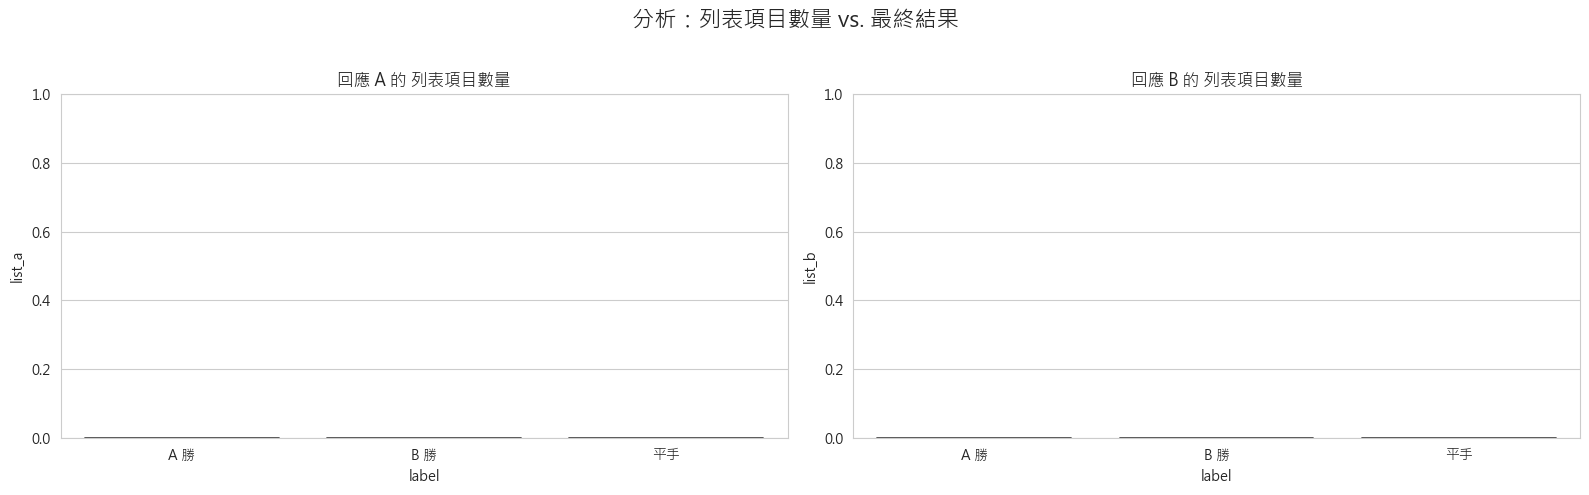

--- 數字統計：列表項目數量 ---
說明：您之前看到的『點點』是數據中的離群值(Outliers)。下面的統計表中，'mean' (平均數) 容易受離群值影響，
而 '50%' (中位數) 則更能代表數據的普遍情況。請重點比較不同 label 下的中位數差異。
        list_a                                      list_b                                   
         count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
label                                                                                        
0      20064.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  20064.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1      19652.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  19652.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2      17761.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  17761.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
--------------------------------------------------------------------------------



C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


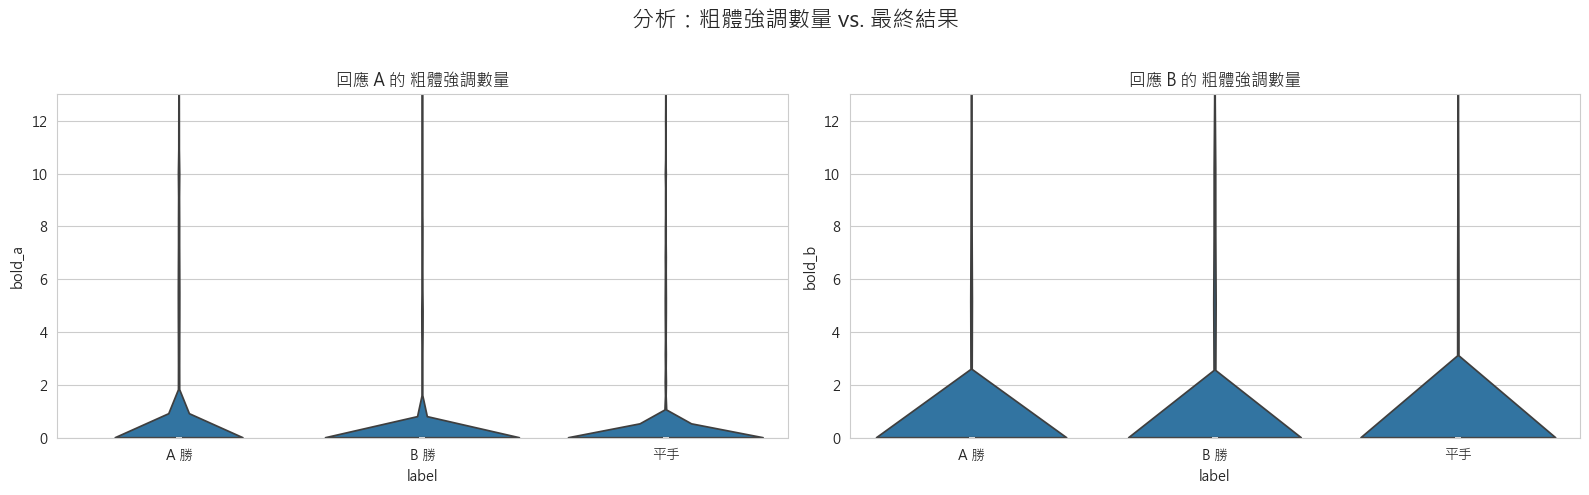

--- 數字統計：粗體強調數量 ---
說明：您之前看到的『點點』是數據中的離群值(Outliers)。下面的統計表中，'mean' (平均數) 容易受離群值影響，
而 '50%' (中位數) 則更能代表數據的普遍情況。請重點比較不同 label 下的中位數差異。
        bold_a                                           bold_b                                         
         count   mean    std  min  25%  50%  75%   max    count   mean    std  min  25%  50%  75%    max
label                                                                                                   
0      20064.0  0.777  3.421  0.0  0.0  0.0  0.0  90.0  20064.0  0.457  3.568  0.0  0.0  0.0  0.0  256.0
1      19652.0  0.409  2.328  0.0  0.0  0.0  0.0  79.0  19652.0  0.764  3.781  0.0  0.0  0.0  0.0  252.0
2      17761.0  0.409  2.275  0.0  0.0  0.0  0.0  52.0  17761.0  0.461  3.401  0.0  0.0  0.0  0.0  307.0
--------------------------------------------------------------------------------



C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


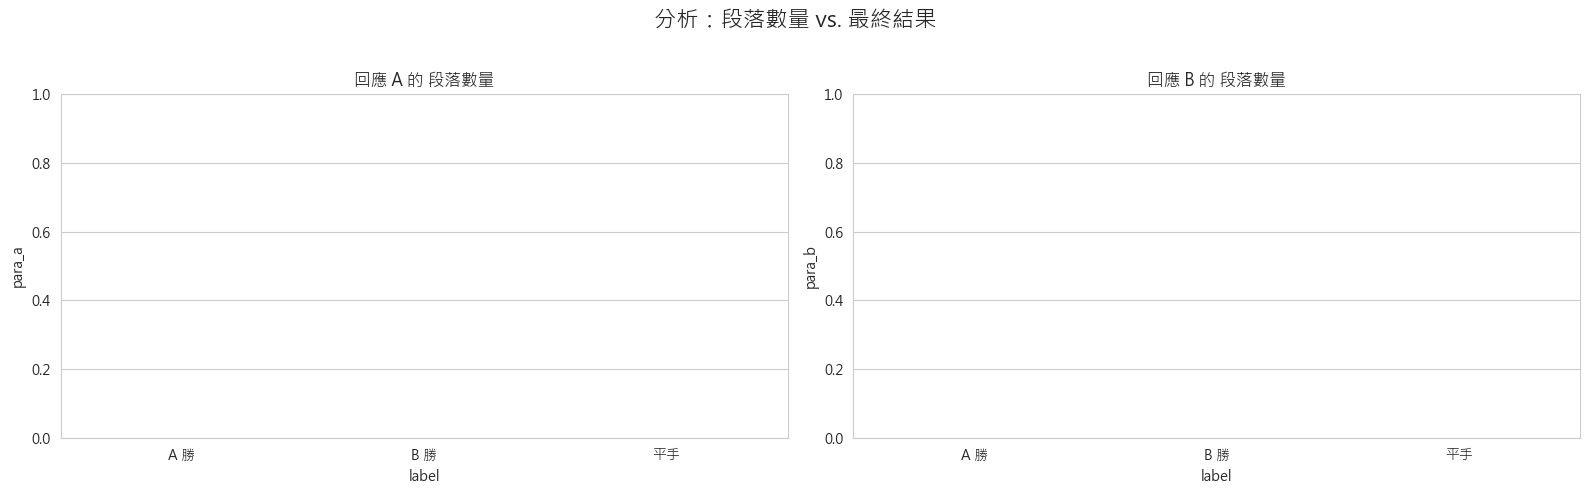

--- 數字統計：段落數量 ---
說明：您之前看到的『點點』是數據中的離群值(Outliers)。下面的統計表中，'mean' (平均數) 容易受離群值影響，
而 '50%' (中位數) 則更能代表數據的普遍情況。請重點比較不同 label 下的中位數差異。
        para_a                                      para_b                                   
         count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
label                                                                                        
0      20064.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  20064.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
1      19652.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  19652.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
2      17761.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  17761.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
--------------------------------------------------------------------------------



C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


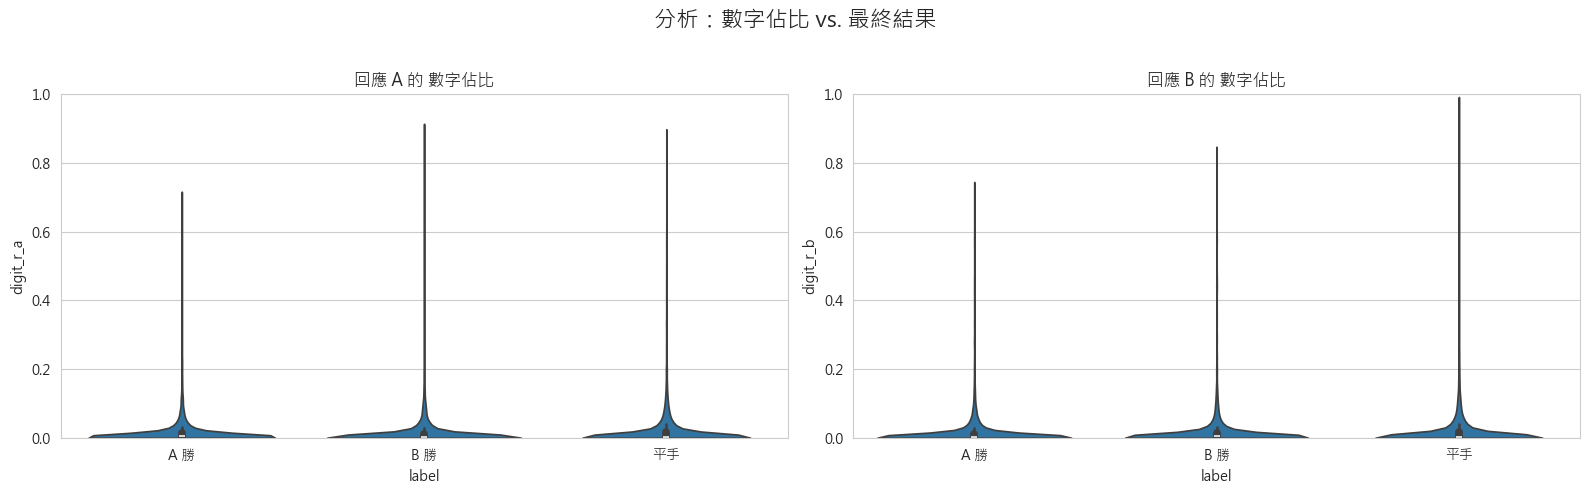

--- 數字統計：數字佔比 ---
說明：您之前看到的『點點』是數據中的離群值(Outliers)。下面的統計表中，'mean' (平均數) 容易受離群值影響，
而 '50%' (中位數) 則更能代表數據的普遍情況。請重點比較不同 label 下的中位數差異。
      digit_r_a                                              digit_r_b                                             
          count   mean    std  min  25%    50%    75%    max     count   mean    std  min  25%    50%    75%    max
label                                                                                                              
0       20064.0  0.019  0.058  0.0  0.0  0.004  0.013  0.717   20064.0  0.018  0.058  0.0  0.0  0.003  0.012  0.745
1       19652.0  0.018  0.057  0.0  0.0  0.003  0.012  0.914   19652.0  0.019  0.059  0.0  0.0  0.004  0.013  0.847
2       17761.0  0.022  0.062  0.0  0.0  0.003  0.016  0.898   17761.0  0.023  0.063  0.0  0.0  0.003  0.016  0.992
--------------------------------------------------------------------------------



C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_17036\990922716.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


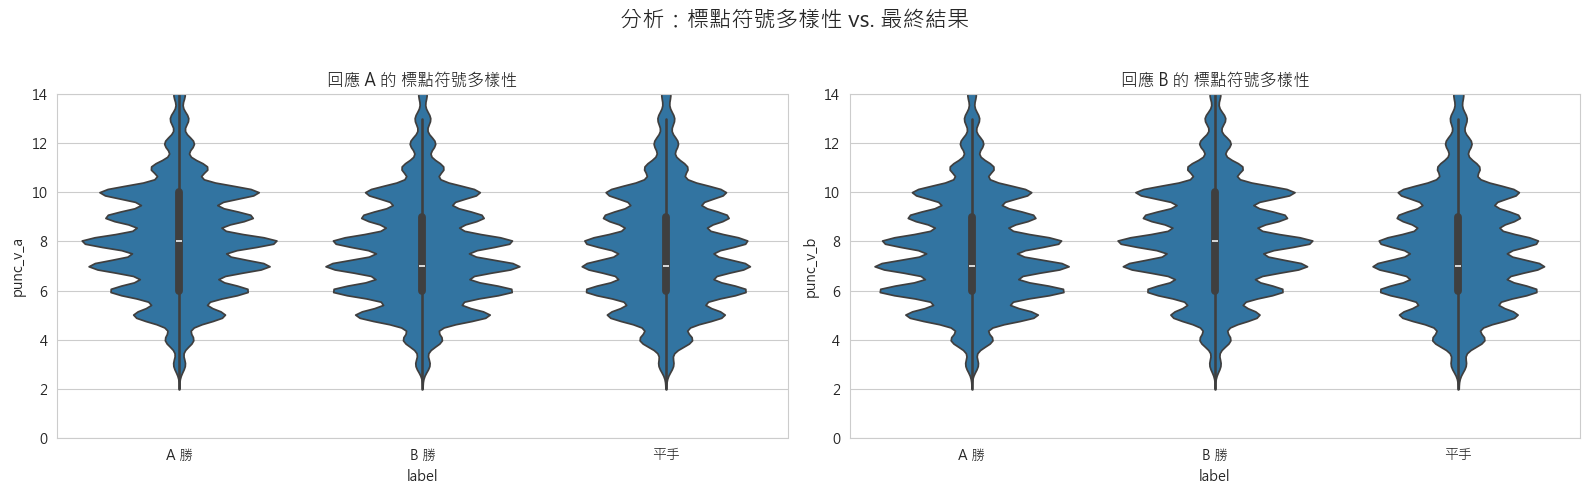

--- 數字統計：標點符號多樣性 ---
說明：您之前看到的『點點』是數據中的離群值(Outliers)。下面的統計表中，'mean' (平均數) 容易受離群值影響，
而 '50%' (中位數) 則更能代表數據的普遍情況。請重點比較不同 label 下的中位數差異。
      punc_v_a                                          punc_v_b                                         
         count   mean    std  min  25%  50%   75%   max    count   mean    std  min  25%  50%   75%   max
label                                                                                                    
0      20064.0  8.026  2.178  2.0  6.0  8.0  10.0  15.0  20064.0  7.573  2.160  2.0  6.0  7.0   9.0  15.0
1      19652.0  7.564  2.170  2.0  6.0  7.0   9.0  15.0  19652.0  8.030  2.184  2.0  6.0  8.0  10.0  15.0
2      17761.0  7.617  2.251  2.0  6.0  7.0   9.0  15.0  17761.0  7.630  2.271  2.0  6.0  7.0   9.0  15.0
--------------------------------------------------------------------------------



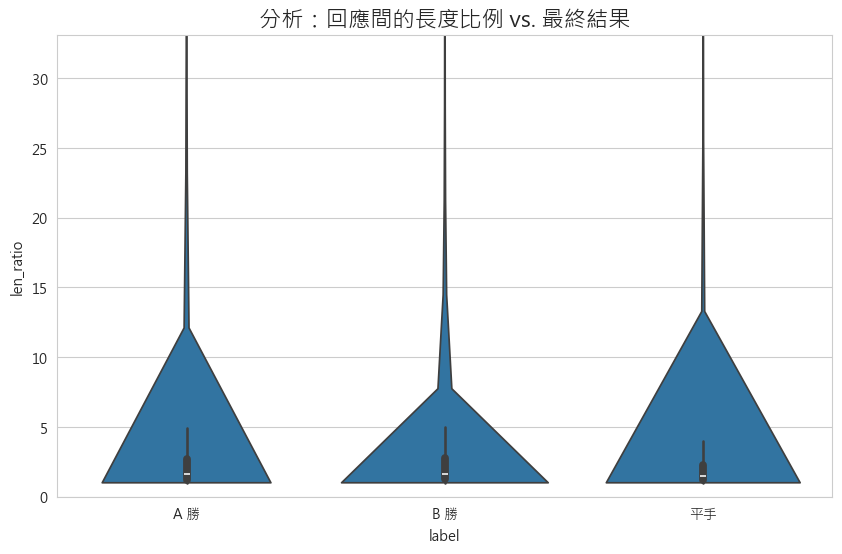

--- 數字統計：回應間的長度比例 ---
      len_ratio                                                  
          count   mean     std  min    25%    50%    75%      max
label                                                            
0       20064.0  3.661  14.633  1.0  1.234  1.636  2.708  1099.75
1       19652.0  3.581  11.021  1.0  1.239  1.646  2.745   668.25
2       17761.0  3.077  12.892  1.0  1.171  1.468  2.290  1216.50
--------------------------------------------------------------------------------



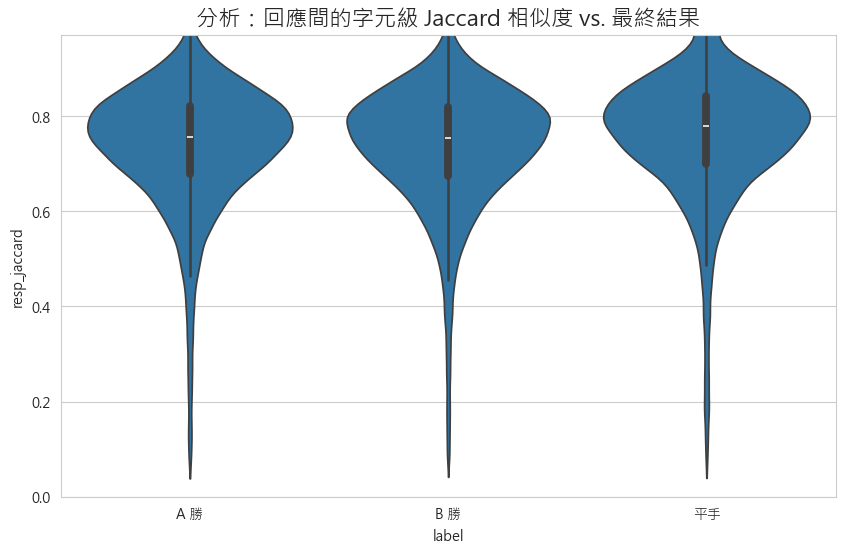

--- 數字統計：回應間的字元級 Jaccard 相似度 ---
      resp_jaccard                                               
             count   mean    std    min    25%    50%    75%  max
label                                                            
0          20064.0  0.734  0.132  0.038  0.677  0.756  0.821  1.0
1          19652.0  0.733  0.130  0.042  0.673  0.754  0.820  1.0
2          17761.0  0.756  0.135  0.039  0.700  0.778  0.842  1.0
--------------------------------------------------------------------------------


--- 進階特徵探索完畢 ---


In [5]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# --- 安全性檢查：確保 df 和 label 欄位存在 ---
if 'df' not in locals() or df.empty:
    print("DataFrame 'df' 不存在或為空，正在重新載入...")
    try:
        df = pd.read_parquet('train_with_language.parquet')
    except FileNotFoundError:
        df = pd.read_csv('train.csv')

if 'label' not in df.columns:
    print("'label' 欄位不存在，正在為您創建...")
    def get_label(row):
        if row['winner_model_a'] == 1: return 0
        if row['winner_model_b'] == 1: return 1
        return 2
    df['label'] = df.apply(get_label, axis=1)
    print("'label' 欄位創建成功！")

# --- 預先計算所有需要的特徵，避免重複計算 ---
# (這部分與上次相同，如果已計算過，可以註解掉以節省時間)
print("\n--- 檢查並計算所有需要的特徵 ---")

# 維度一 & 二的函式
def count_list_items(text): return len(re.findall(r'^\s*[\*\-]\s|\n\s*[\*\-]\s|^\s*\d+\.\s|\n\s*\d+\.\s', str(text), re.MULTILINE))
def count_bold_emphasis(text): return len(re.findall(r'\*\*(.*?)\*\*|__(.*?)__', str(text)))
def count_paragraphs(text): return len(re.split(r'\n\s*\n', str(text).strip()))
def digit_ratio(text):
    text = str(text)
    if not text: return 0
    return len(re.findall(r'\d', text)) / len(text)
def punctuation_variety(text): return len(set(re.findall(r'[.,!?;:(){}\[\]\'\"-]', str(text))))

# 維度三的函式
def calculate_length_ratio(len_a, len_b):
    if min(len_a, len_b) == 0: return 1
    return max(len_a, len_b) / min(len_a, len_b)
def get_char_jaccard_similarity(text1, text2):
    set1, set2 = set(str(text1)), set(str(text2))
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# 應用計算
features_to_calc = {'list': count_list_items, 'bold': count_bold_emphasis, 'para': count_paragraphs, 'digit_r': digit_ratio, 'punc_v': punctuation_variety}
for name, func in features_to_calc.items():
    if f'{name}_a' not in df.columns:
        print(f"正在計算特徵: {name}...")
        tqdm.pandas(desc=f"計算 {name}_a")
        df[f'{name}_a'] = df['response_a'].progress_apply(func)
        tqdm.pandas(desc=f"計算 {name}_b")
        df[f'{name}_b'] = df['response_b'].progress_apply(func)

if 'len_ratio' not in df.columns:
    print("正在計算互動特徵...")
    if 'len_a' not in df.columns: df['len_a'] = df['response_a'].str.len()
    if 'len_b' not in df.columns: df['len_b'] = df['response_b'].str.len()
    df['len_ratio'] = df.apply(lambda row: calculate_length_ratio(row['len_a'], row['len_b']), axis=1)
    df['resp_jaccard'] = df.apply(lambda row: get_char_jaccard_similarity(row['response_a'], row['response_b']), axis=1)

print("\n--- 所有特徵已準備就緒，開始分析與視覺化 ---")

# ==============================================================================
#  視覺化分析與數字統計
# ==============================================================================

# --- 分析維度一 & 二的特徵 (A/B 對比) ---
features_to_plot_ab = {
    'list': '列表項目數量',
    'bold': '粗體強調數量',
    'para': '段落數量',
    'digit_r': '數字佔比',
    'punc_v': '標點符號多樣性'
}

for key, name in features_to_plot_ab.items():
    # 1. 繪製優化後的圖表
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f'分析：{name} vs. 最終結果', fontsize=16)

    # 改用小提琴圖 (Violin Plot) 來更清晰地展示分佈
    sns.violinplot(x='label', y=f'{key}_a', data=df, ax=axes[0], cut=0)
    axes[0].set_title(f'回應 A 的 {name}')
    axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
    axes[0].set_ylim(0, max(1, df[f'{key}_a'].quantile(0.99))) # 縮放 Y 軸以觀察主要分佈

    sns.violinplot(x='label', y=f'{key}_b', data=df, ax=axes[1], cut=0)
    axes[1].set_title(f'回應 B 的 {name}')
    axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])
    axes[1].set_ylim(0, max(1, df[f'{key}_b'].quantile(0.99)))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 2. 附上精確的數字統計
    print(f"--- 數字統計：{name} ---")
    print("說明：您之前看到的『點點』是數據中的離群值(Outliers)。下面的統計表中，'mean' (平均數) 容易受離群值影響，")
    print("而 '50%' (中位數) 則更能代表數據的普遍情況。請重點比較不同 label 下的中位數差異。")
    # 使用 .describe() 提供完整的統計數據
    print(df.groupby('label')[[f'{key}_a', f'{key}_b']].describe().round(3))
    print("-" * 80 + "\n")


# --- 分析維度三的特徵 (互動特徵) ---
features_to_plot_single = {
    'len_ratio': '回應間的長度比例',
    'resp_jaccard': '回應間的字元級 Jaccard 相似度'
}

for key, name in features_to_plot_single.items():
    # 1. 繪製優化後的圖表
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='label', y=key, data=df, cut=0)
    plt.title(f'分析：{name} vs. 最終結果', fontsize=16)
    plt.xticks(ticks=[0, 1, 2], labels=['A 勝', 'B 勝', '平手'])
    plt.ylim(0, df[key].quantile(0.99))
    plt.show()

    # 2. 附上精確的數字統計
    print(f"--- 數字統計：{name} ---")
    print(df.groupby('label')[[key]].describe().round(3))
    print("-" * 80 + "\n")

print("\n--- 進階特徵探索完畢 ---")

# 調查token數量

--- 開始分析最終輸入文本的估計 Token 長度 ---


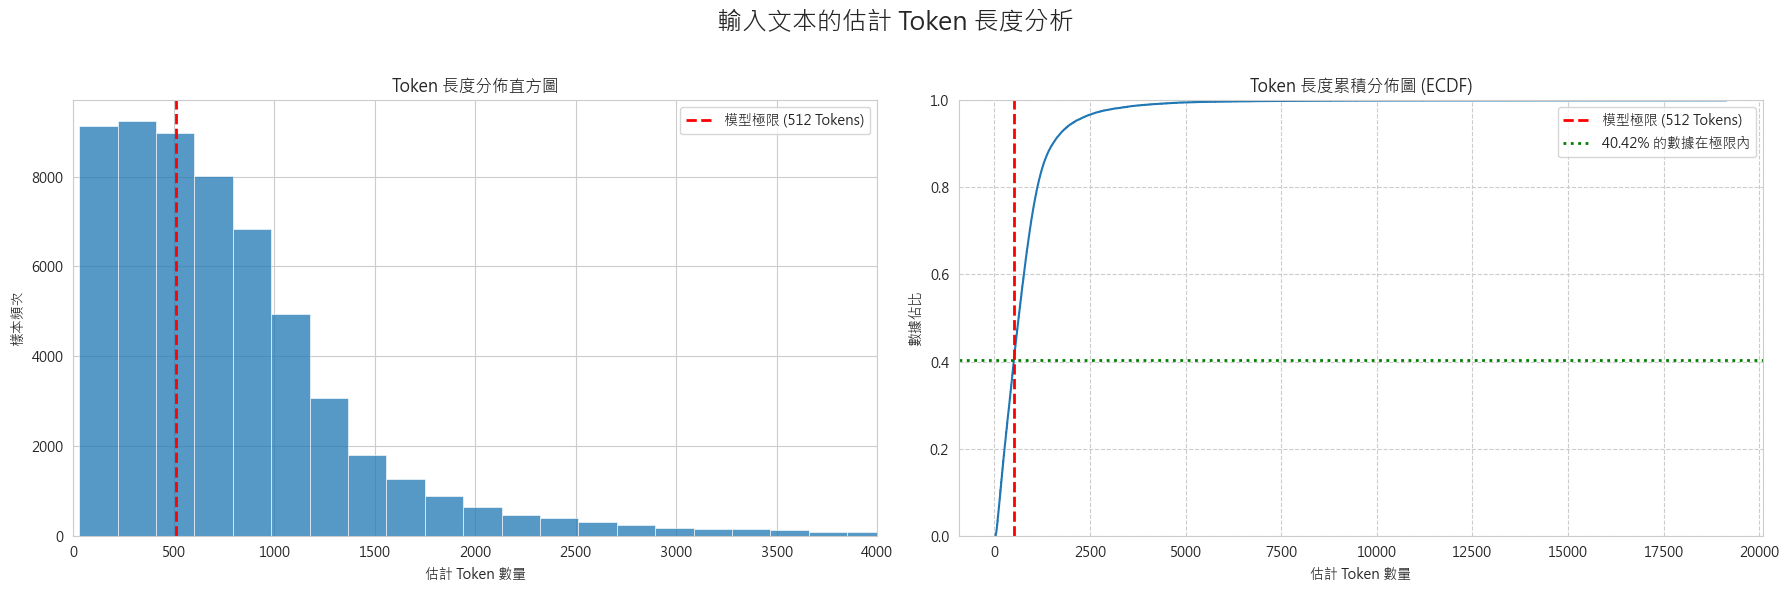


--- 精確數字統計 ---
模型 Token 上限: 512
count    57477.00
mean       805.67
std        808.11
min         28.75
25%        326.75
50%        634.25
75%       1014.25
max      19139.75
Name: estimated_tokens, dtype: float64
----------------------------------------
估計會超出長度限制的樣本數量: 34243 / 57477
估計會被截斷的數據佔比: 59.58%
----------------------------------------

⚠️ 警告：有超過 10% 的數據可能會被截斷！這可能會嚴重影響模型性能。
建議措施：在預處理時，考慮對 prompt 或 response 進行更積極的裁切，為元數據保留空間。


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 安全性檢查：確保 df 和我們需要的特徵存在 ---
# 這裡假設 df 已經被載入，並且 'label' 欄位已創建
# 我們還需要 'punc_v_a', 'punc_v_b', 'len_ratio', 'resp_jaccard'
# 如果這些特徵不存在，這個 cell 會跳過執行並提示
required_features = ['prompt', 'response_a', 'response_b', 'punc_v_a', 'punc_v_b', 'len_ratio', 'resp_jaccard']
if 'df' not in locals() or not all(col in df.columns for col in required_features):
    print("錯誤：'df' 或必要的特徵欄位不存在。請先執行之前的特徵計算 CELL。")
    print(f"缺失的欄位: {[col for col in required_features if col not in df.columns]}")
else:
    print("--- 開始分析最終輸入文本的估計 Token 長度 ---")

    # --- 1. 模擬最終輸入文本的構建過程 ---
    def build_final_input_text(row):
        """
        模擬模型接收到的最終輸入文本格式。
        """
        # 基礎文本部分
        prompt = str(row['prompt'])
        response_a = str(row['response_a'])
        response_b = str(row['response_b'])
        
        # 我們選定的元數據特徵
        # 這裡我們將數字格式化，以模擬它們變成字串後的長度
        punc_v_a = row['punc_v_a']
        punc_v_b = row['punc_v_b']
        len_ratio = row['len_ratio']
        resp_jaccard = row['resp_jaccard']

        metadata_str = (
            f"[METADATA] "
            f"punc_v_a:{punc_v_a}, punc_v_b:{punc_v_b}, "
            f"len_ratio:{len_ratio:.2f}, resp_jaccard:{resp_jaccard:.2f}"
        )
        
        # 組合所有部分，並用 [SEP] 分隔
        final_text = (
            f"{prompt} [SEP] {response_a} [SEP] {response_b} [SEP] {metadata_str}"
        )
        return final_text

    # 應用函式來創建包含所有資訊的最終文本
    df['final_text'] = df.apply(build_final_input_text, axis=1)

    # --- 2. 計算估計的 Token 長度 ---
    # 經驗法則：1 Token ≈ 4 字元
    TOKEN_PER_CHAR = 4 
    df['estimated_tokens'] = df['final_text'].str.len() / TOKEN_PER_CHAR
    
    # --- 3. 視覺化分析 ---
    MODEL_TOKEN_LIMIT = 512

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('輸入文本的估計 Token 長度分析', fontsize=18)

    # 左圖：直方圖 (Histogram)
    sns.histplot(df['estimated_tokens'], bins=100, ax=axes[0])
    axes[0].set_title('Token 長度分佈直方圖')
    axes[0].set_xlabel('估計 Token 數量')
    axes[0].set_ylabel('樣本頻次')
    axes[0].axvline(x=MODEL_TOKEN_LIMIT, color='r', linestyle='--', linewidth=2, label=f'模型極限 ({MODEL_TOKEN_LIMIT} Tokens)')
    axes[0].legend()
    # 為了看清主要分佈，可以限制 x 軸範圍
    axes[0].set_xlim(0, df['estimated_tokens'].quantile(0.99))

    # 右圖：累積分佈圖 (ECDF Plot)
    sns.ecdfplot(data=df, x='estimated_tokens', ax=axes[1])
    axes[1].set_title('Token 長度累積分佈圖 (ECDF)')
    axes[1].set_xlabel('估計 Token 數量')
    axes[1].set_ylabel('數據佔比')
    axes[1].grid(True, which="both", ls="--")
    # 標出模型極限線
    axes[1].axvline(x=MODEL_TOKEN_LIMIT, color='r', linestyle='--', linewidth=2, label=f'模型極限 ({MODEL_TOKEN_LIMIT} Tokens)')
    
    # 在極限線對應的 Y 軸上標出被截斷的比例
    try:
        # 計算在極限值時，Y 軸對應的百分比
        percentile_at_limit = df[df['estimated_tokens'] <= MODEL_TOKEN_LIMIT].shape[0] / len(df)
        axes[1].axhline(y=percentile_at_limit, color='g', linestyle=':', linewidth=2, label=f'{percentile_at_limit:.2%} 的數據在極限內')
    except Exception as e:
        print(f"無法計算百分位數: {e}")
        
    axes[1].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- 4. 提供精確的數字統計 ---
    exceeding_count = df[df['estimated_tokens'] > MODEL_TOKEN_LIMIT].shape[0]
    exceeding_percentage = (exceeding_count / len(df)) * 100

    print("\n--- 精確數字統計 ---")
    print(f"模型 Token 上限: {MODEL_TOKEN_LIMIT}")
    print(df['estimated_tokens'].describe().round(2))
    print("-" * 40)
    print(f"估計會超出長度限制的樣本數量: {exceeding_count} / {len(df)}")
    print(f"估計會被截斷的數據佔比: {exceeding_percentage:.2f}%")
    print("-" * 40)

    if exceeding_percentage > 10:
        print("\n⚠️ 警告：有超過 10% 的數據可能會被截斷！這可能會嚴重影響模型性能。")
        print("建議措施：在預處理時，考慮對 prompt 或 response 進行更積極的裁切，為元數據保留空間。")
    elif exceeding_percentage > 1:
        print("\n✅ 結論：大部分數據都在長度限制內。少量的截斷是正常的，目前的輸入格式是可接受的。")
    else:
        print("\n🎉 優秀！幾乎所有數據都在長度限制內，無需擔心截斷問題。")

# 進階資料

# TTR (Type-Token Ratio) 分析
TTR (Type-Token Ratio) 是衡量文本詞彙多樣性的重要指標，計算方式為：**獨特詞彙數量 / 總詞彙數量**

- TTR 值越高，表示文本的詞彙使用越多樣化
- TTR 值越低，表示文本重複使用相同詞彙的情況越多
- 這個指標可以反映回應的語言豐富程度和表達能力

--- 開始計算 TTR (Type-Token Ratio) 特徵 ---
正在計算回應 A 的 TTR...


計算 TTR_A:   0%|          | 0/57477 [00:00<?, ?it/s]

正在計算回應 B 的 TTR...


計算 TTR_B:   0%|          | 0/57477 [00:00<?, ?it/s]

TTR 特徵計算完成！


C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3684781310.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3684781310.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])
C:\Users\asas1\AppData\Local\Temp\ipykernel_26088\3684781310.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])


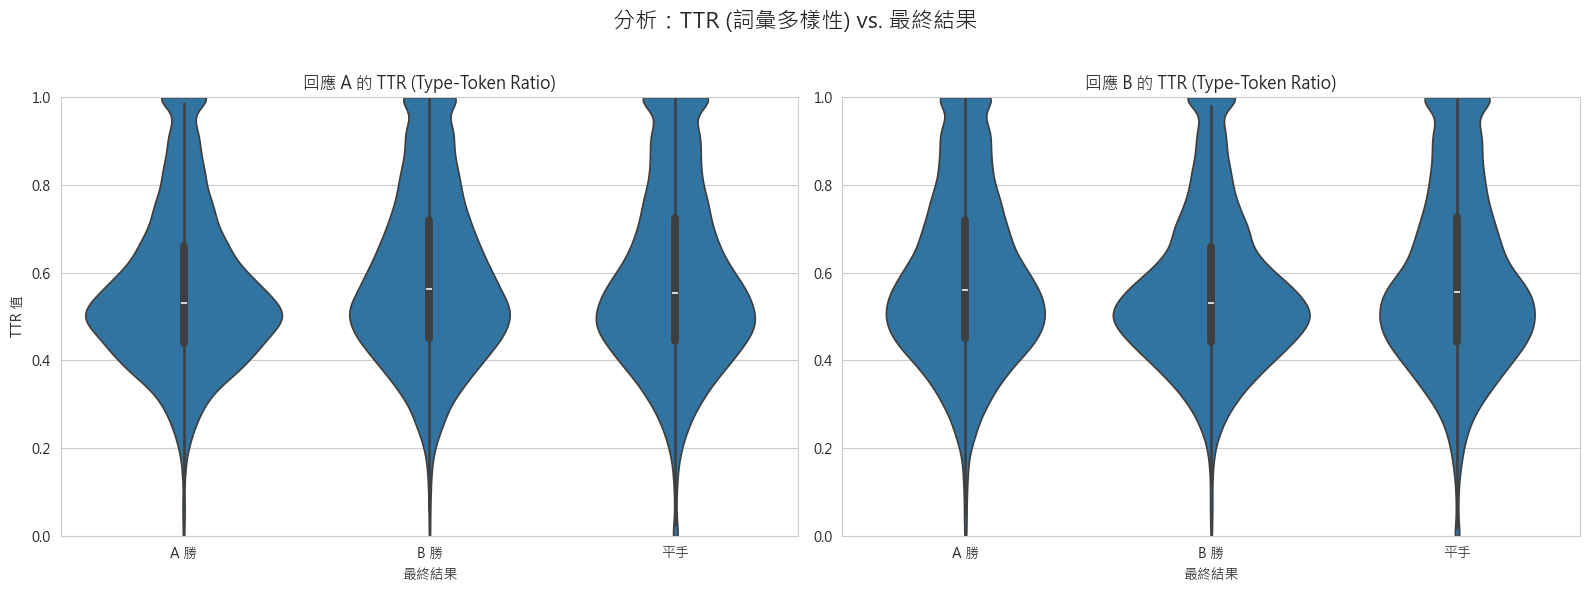

--- TTR 數字統計 ---
說明：TTR 值範圍為 0-1，值越高表示詞彙使用越多樣化
比較不同 label 下的中位數和平均數差異：
         ttr_a                                                      ttr_b                                                  
         count    mean     std  min     25%     50%     75%  max    count    mean     std  min     25%     50%     75%  max
label                                                                                                                      
0      20064.0  0.5617  0.1808  0.0  0.4396  0.5307  0.6608  1.0  20064.0  0.5891  0.1966  0.0  0.4510  0.5608  0.7193  1.0
1      19652.0  0.5904  0.1953  0.0  0.4519  0.5619  0.7200  1.0  19652.0  0.5612  0.1814  0.0  0.4408  0.5305  0.6575  1.0
2      17761.0  0.5877  0.2065  0.0  0.4440  0.5534  0.7237  1.0  17761.0  0.5886  0.2071  0.0  0.4426  0.5550  0.7260  1.0

--- TTR 互動特徵分析 ---

--- TTR 互動特徵分析 ---


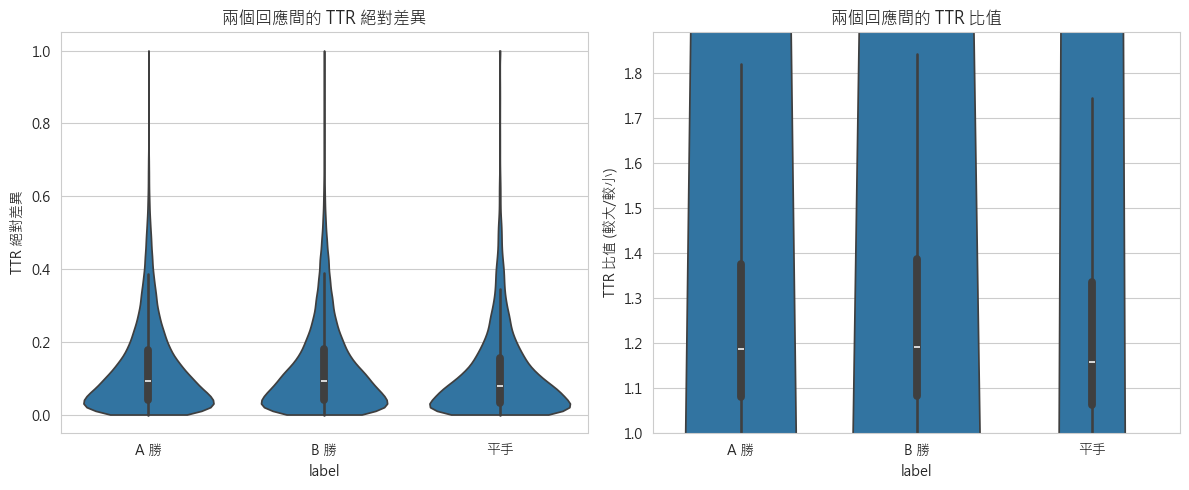

TTR 差異和比值的統計：
      ttr_diff                                                   ttr_ratio                                                      
         count    mean     std  min     25%     50%     75%  max     count    mean      std  min     25%     50%     75%     max
label                                                                                                                           
0      20064.0  0.1281  0.1225  0.0  0.0399  0.0909  0.1779  1.0   20064.0  2.2685  26.5836  0.0  1.0784  1.1863  1.3747  1000.0
1      19652.0  0.1303  0.1237  0.0  0.0408  0.0934  0.1804  1.0   19652.0  2.0282  22.3670  0.0  1.0807  1.1895  1.3852  1000.0
2      17761.0  0.1156  0.1229  0.0  0.0319  0.0778  0.1566  1.0   17761.0  3.7909  47.1862  0.0  1.0615  1.1571  1.3347  1000.0

--- TTR 分析結論 ---
各類別下的 TTR 中位數：
A 勝: TTR_A = 0.5307, TTR_B = 0.5608
B 勝: TTR_A = 0.5619, TTR_B = 0.5305
平手: TTR_A = 0.5534, TTR_B = 0.5550

🤔 TTR 模式不太明確，需要結合其他特徵進行綜合判斷

--- TTR 特徵已加入分析完畢 ---


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re

# --- 安全性檢查：確保 df 和 label 欄位存在 ---
if 'df' not in locals() or df.empty:
    print("DataFrame 'df' 不存在或為空，正在重新載入...")
    try:
        df = pd.read_parquet('train_with_language.parquet')
    except FileNotFoundError:
        df = pd.read_csv('train.csv')

if 'label' not in df.columns:
    print("'label' 欄位不存在，正在為您創建...")
    def get_label(row):
        if row['winner_model_a'] == 1: return 0
        if row['winner_model_b'] == 1: return 1
        return 2
    df['label'] = df.apply(get_label, axis=1)

print("--- 開始計算 TTR (Type-Token Ratio) 特徵 ---")

# --- TTR 計算函式 ---
def calculate_ttr(text):
    """
    計算 Type-Token Ratio (TTR)
    TTR = 獨特詞彙數量 / 總詞彙數量
    """
    if not isinstance(text, str) or not text.strip():
        return 0
    
    # 將文本轉為小寫並分割成詞彙
    # 使用正則表達式來分割，保留字母和數字
    words = re.findall(r'\b\w+\b', text.lower())
    
    if len(words) == 0:
        return 0
    
    # 計算獨特詞彙數量
    unique_words = len(set(words))
    total_words = len(words)
    
    return unique_words / total_words

# --- 計算 TTR 特徵 ---
if 'ttr_a' not in df.columns:
    print("正在計算回應 A 的 TTR...")
    tqdm.pandas(desc="計算 TTR_A")
    df['ttr_a'] = df['response_a'].progress_apply(calculate_ttr)
    
if 'ttr_b' not in df.columns:
    print("正在計算回應 B 的 TTR...")
    tqdm.pandas(desc="計算 TTR_B")
    df['ttr_b'] = df['response_b'].progress_apply(calculate_ttr)

print("TTR 特徵計算完成！")

# --- 視覺化分析 TTR ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('分析：TTR (詞彙多樣性) vs. 最終結果', fontsize=16)

# 左圖：回應 A 的 TTR
sns.violinplot(x='label', y='ttr_a', data=df, ax=axes[0], cut=0)
axes[0].set_title('回應 A 的 TTR (Type-Token Ratio)')
axes[0].set_xticklabels(['A 勝', 'B 勝', '平手'])
axes[0].set_xlabel('最終結果')
axes[0].set_ylabel('TTR 值')
# 由於 TTR 值在 0-1 之間，我們可以顯示完整範圍
axes[0].set_ylim(0, 1)

# 右圖：回應 B 的 TTR
sns.violinplot(x='label', y='ttr_b', data=df, ax=axes[1], cut=0)
axes[1].set_title('回應 B 的 TTR (Type-Token Ratio)')
axes[1].set_xticklabels(['A 勝', 'B 勝', '平手'])
axes[1].set_xlabel('最終結果')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 數字統計分析 ---
print("--- TTR 數字統計 ---")
print("說明：TTR 值範圍為 0-1，值越高表示詞彙使用越多樣化")
print("比較不同 label 下的中位數和平均數差異：")
print(df.groupby('label')[['ttr_a', 'ttr_b']].describe().round(4))

# --- 進一步分析：TTR 差異 ---
df['ttr_diff'] = abs(df['ttr_a'] - df['ttr_b'])
df['ttr_ratio'] = df.apply(lambda row: max(row['ttr_a'], row['ttr_b']) / max(min(row['ttr_a'], row['ttr_b']), 0.001), axis=1)

print("\n--- TTR 互動特徵分析 ---")

# TTR 差異分析
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.violinplot(x='label', y='ttr_diff', data=df, cut=0)
plt.title('兩個回應間的 TTR 絕對差異')
plt.xticks(ticks=[0, 1, 2], labels=['A 勝', 'B 勝', '平手'])
plt.ylabel('TTR 絕對差異')

plt.subplot(1, 2, 2)
sns.violinplot(x='label', y='ttr_ratio', data=df, cut=0)
plt.title('兩個回應間的 TTR 比值')
plt.xticks(ticks=[0, 1, 2], labels=['A 勝', 'B 勝', '平手'])
plt.ylabel('TTR 比值 (較大/較小)')
plt.ylim(1, df['ttr_ratio'].quantile(0.95))  # 限制 Y 軸以便觀察

plt.tight_layout()
plt.show()

print("TTR 差異和比值的統計：")
print(df.groupby('label')[['ttr_diff', 'ttr_ratio']].describe().round(4))

# --- 結論與洞察 ---
print("\n--- TTR 分析結論 ---")
ttr_a_by_label = df.groupby('label')['ttr_a'].median()
ttr_b_by_label = df.groupby('label')['ttr_b'].median()

print("各類別下的 TTR 中位數：")
for label, desc in [(0, 'A 勝'), (1, 'B 勝'), (2, '平手')]:
    print(f"{desc}: TTR_A = {ttr_a_by_label[label]:.4f}, TTR_B = {ttr_b_by_label[label]:.4f}")

# 檢查是否有明顯趨勢
if ttr_a_by_label[0] > ttr_a_by_label[1] and ttr_b_by_label[1] > ttr_b_by_label[0]:
    print("\n✅ 發現明顯趨勢：勝利的回應往往具有較高的 TTR（詞彙多樣性）")
    print("這表明詞彙豐富程度可能是一個有價值的特徵！")
elif abs(ttr_a_by_label[0] - ttr_a_by_label[1]) < 0.01 and abs(ttr_b_by_label[0] - ttr_b_by_label[1]) < 0.01:
    print("\n📊 TTR 在不同類別間差異很小，可能不是一個強預測特徵")
    print("但仍可作為輔助特徵使用")
else:
    print("\n🤔 TTR 模式不太明確，需要結合其他特徵進行綜合判斷")

print("\n--- TTR 特徵已加入分析完畢 ---")